In [182]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import os

def find_file_with_id(file_id,root_dir='../results'):
    """Find a file containing the given ID in the results directory structure"""
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if file_id in filename:
                # Return path relative to current directory
                return os.path.relpath(os.path.join(dirpath, filename))
    return None

file_path = find_file_with_id(file_id='74726')
print(file_path)

# Open the .h5 file in read mode
with h5py.File(file_path, 'r') as file:
    # Print the names of the groups/datasets in the file
    print("Keys in the file:", list(file.keys()))
    
    # Assuming there's a dataset named 'data' in the file
    # Modify this part according to your file's structure
    data = file['datasets']
    print(file['datasets'].keys())

    print(file['archive'].keys())
    #print(file['archive']['__param__SDF'].keys())

    print(file['expid'][()])
            
    rabi_t= data['beta_index'][:]
    pmt_count=data['pmt_counts_avg_thresholded'][:]

# # Path to your .h5 file
# file_path =  '../results/2025-05-02/16/000073789-A7_Sync_VdP2_Px1x2.h5'

# # Open the .h5 file in read mode
# with h5py.File(file_path, 'r') as file:
#     # Print the names of the groups/datasets in the file
#     print("Keys in the file:", list(file.keys()))
    
#     # Assuming there's a dataset named 'data' in the file
#     # Modify this part according to your file's structure
#     data = file['datasets']
#     print(file['datasets'].keys())

#     print(file['archive'].keys())
#     #print(file['archive']['__param__SDF'].keys())

#     print(file['expid'][()])
            
#     rabi_t= data['beta_index'][:]
#     pmt_count+=data['pmt_counts_avg_thresholded'][:]

plt.figure()
plt.plot(rabi_t, pmt_count)
plt.scatter(rabi_t, pmt_count,c='red',s=20)
plt.xlabel('${\\rm t}(\mu s)$')
plt.ylabel('<z>')


In [184]:
pmt_count=pmt_count.reshape(int(np.sqrt(len(pmt_count))),int(np.sqrt(len(pmt_count))))

In [185]:
eta1=0.134#
0.094246#0.071655#0.094246#0.071655#0.094246
#0.134/np.sqrt(2)
#0.134/np.sqrt(2)
print(eta1)
eta2=0.134#
0.071655#0.094246#0.071655#0.094246#0.071655#
#0.134/np.sqrt(2)*np.sqrt(0.526/0.901)

Rabi_readout1=0.1*2*np.pi
Rabi_readout2=0.1*2*np.pi
beta_time_range_us1 = 60
beta_time_range_us2 = 60

beta_range1=eta1*Rabi_readout1*beta_time_range_us1
beta_range2=eta2*Rabi_readout2*beta_time_range_us2
print(beta_range1, beta_range2)

0.134
5.051680986972388 5.051680986972388


In [186]:
#pmt_count[0,7] = (pmt_count[0,6] + pmt_count[0,8])/2
#pmt_count[6,11] = (pmt_count[6,10]+ pmt_count[6,12])/2
#pmt_count[17,11] = (pmt_count[17,10]+pmt_count[17,12])/2

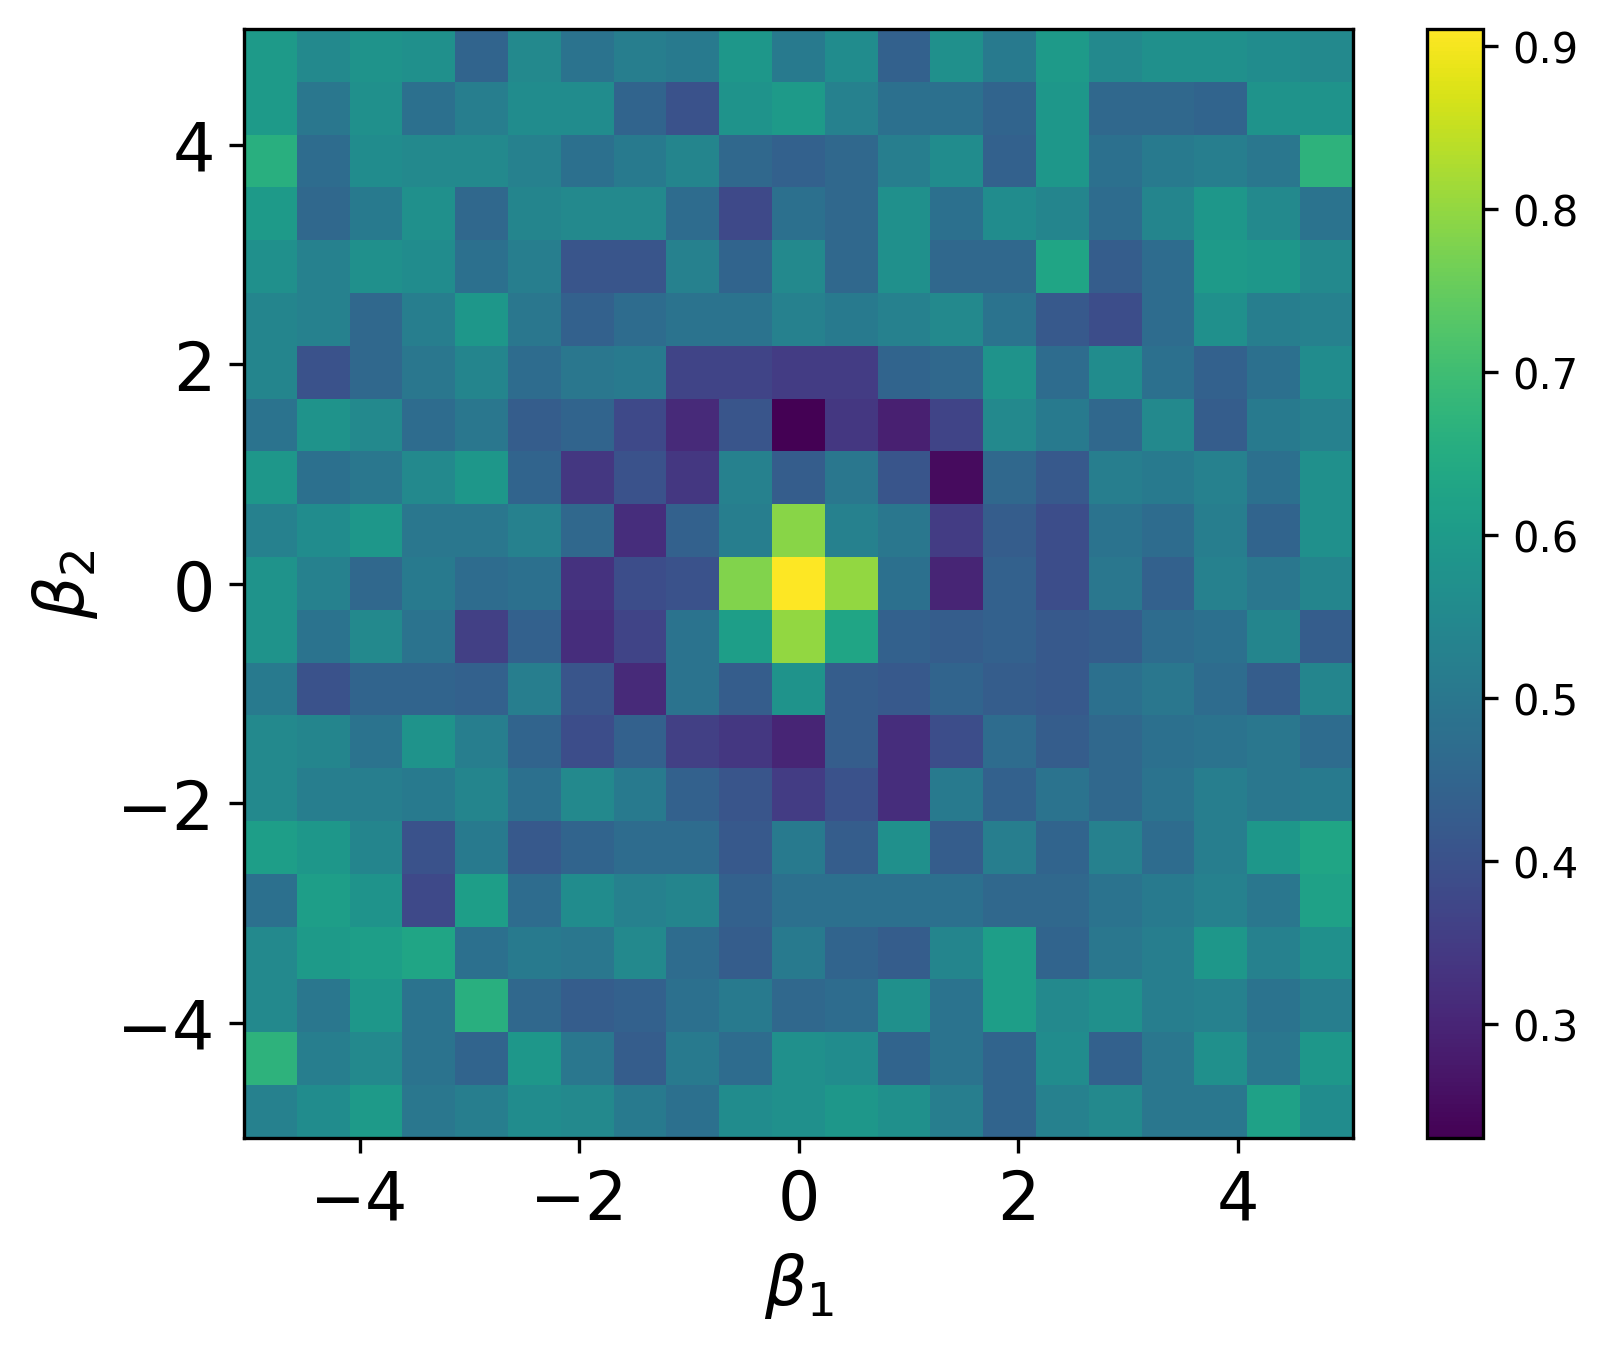

In [187]:
import matplotlib.colors as mcolors
cmap = plt.cm.viridis  # You can choose any colormap
cmap = cmap.copy()     # Copy the colormap to modify it
cmap.set_bad(color='gray')  # Set NaN values to gray

# pmt_count=pmt_count/2+pmt_count.T/2

plt.figure(dpi=300)

plt.imshow(pmt_count, cmap=cmap, extent=[-beta_range1,beta_range1,-beta_range2,beta_range2])#, aspect=beta_range1/beta_range2)
plt.xlabel('$\\beta_1$',fontsize=16)
plt.ylabel('$\\beta_2$',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar()

In [188]:
from scipy.ndimage import zoom


def interpolate_2d(data, upscale_factor=2, method='bicubic', padding=0):
    if method == 'bilinear':
        order = 1
    elif method == 'bicubic':
        order = 3
    else:
        raise ValueError("Invalid method. Choose 'bilinear' or 'bicubic'.")
    
    interpolated_data = zoom(data, zoom=upscale_factor, order=order)
    
    if padding > 0:
        interpolated_data = np.pad(interpolated_data, pad_width=padding, mode='constant', constant_values=0.5)
    
    return interpolated_data

pmt_count[-1]=pmt_count[1]
pmt_interpolate=interpolate_2d(pmt_count, upscale_factor=1)

In [189]:
L=len(pmt_interpolate)
offset=(np.sum(pmt_interpolate)-np.sum(pmt_interpolate[L//6:L*5//6, L//6:L*5//6]))/(L*L-(L*5//6-L//6)**2)
offset-=0.000
print(offset)

0.5218775510204083


Text(0.5, 1.0, 'Real part')

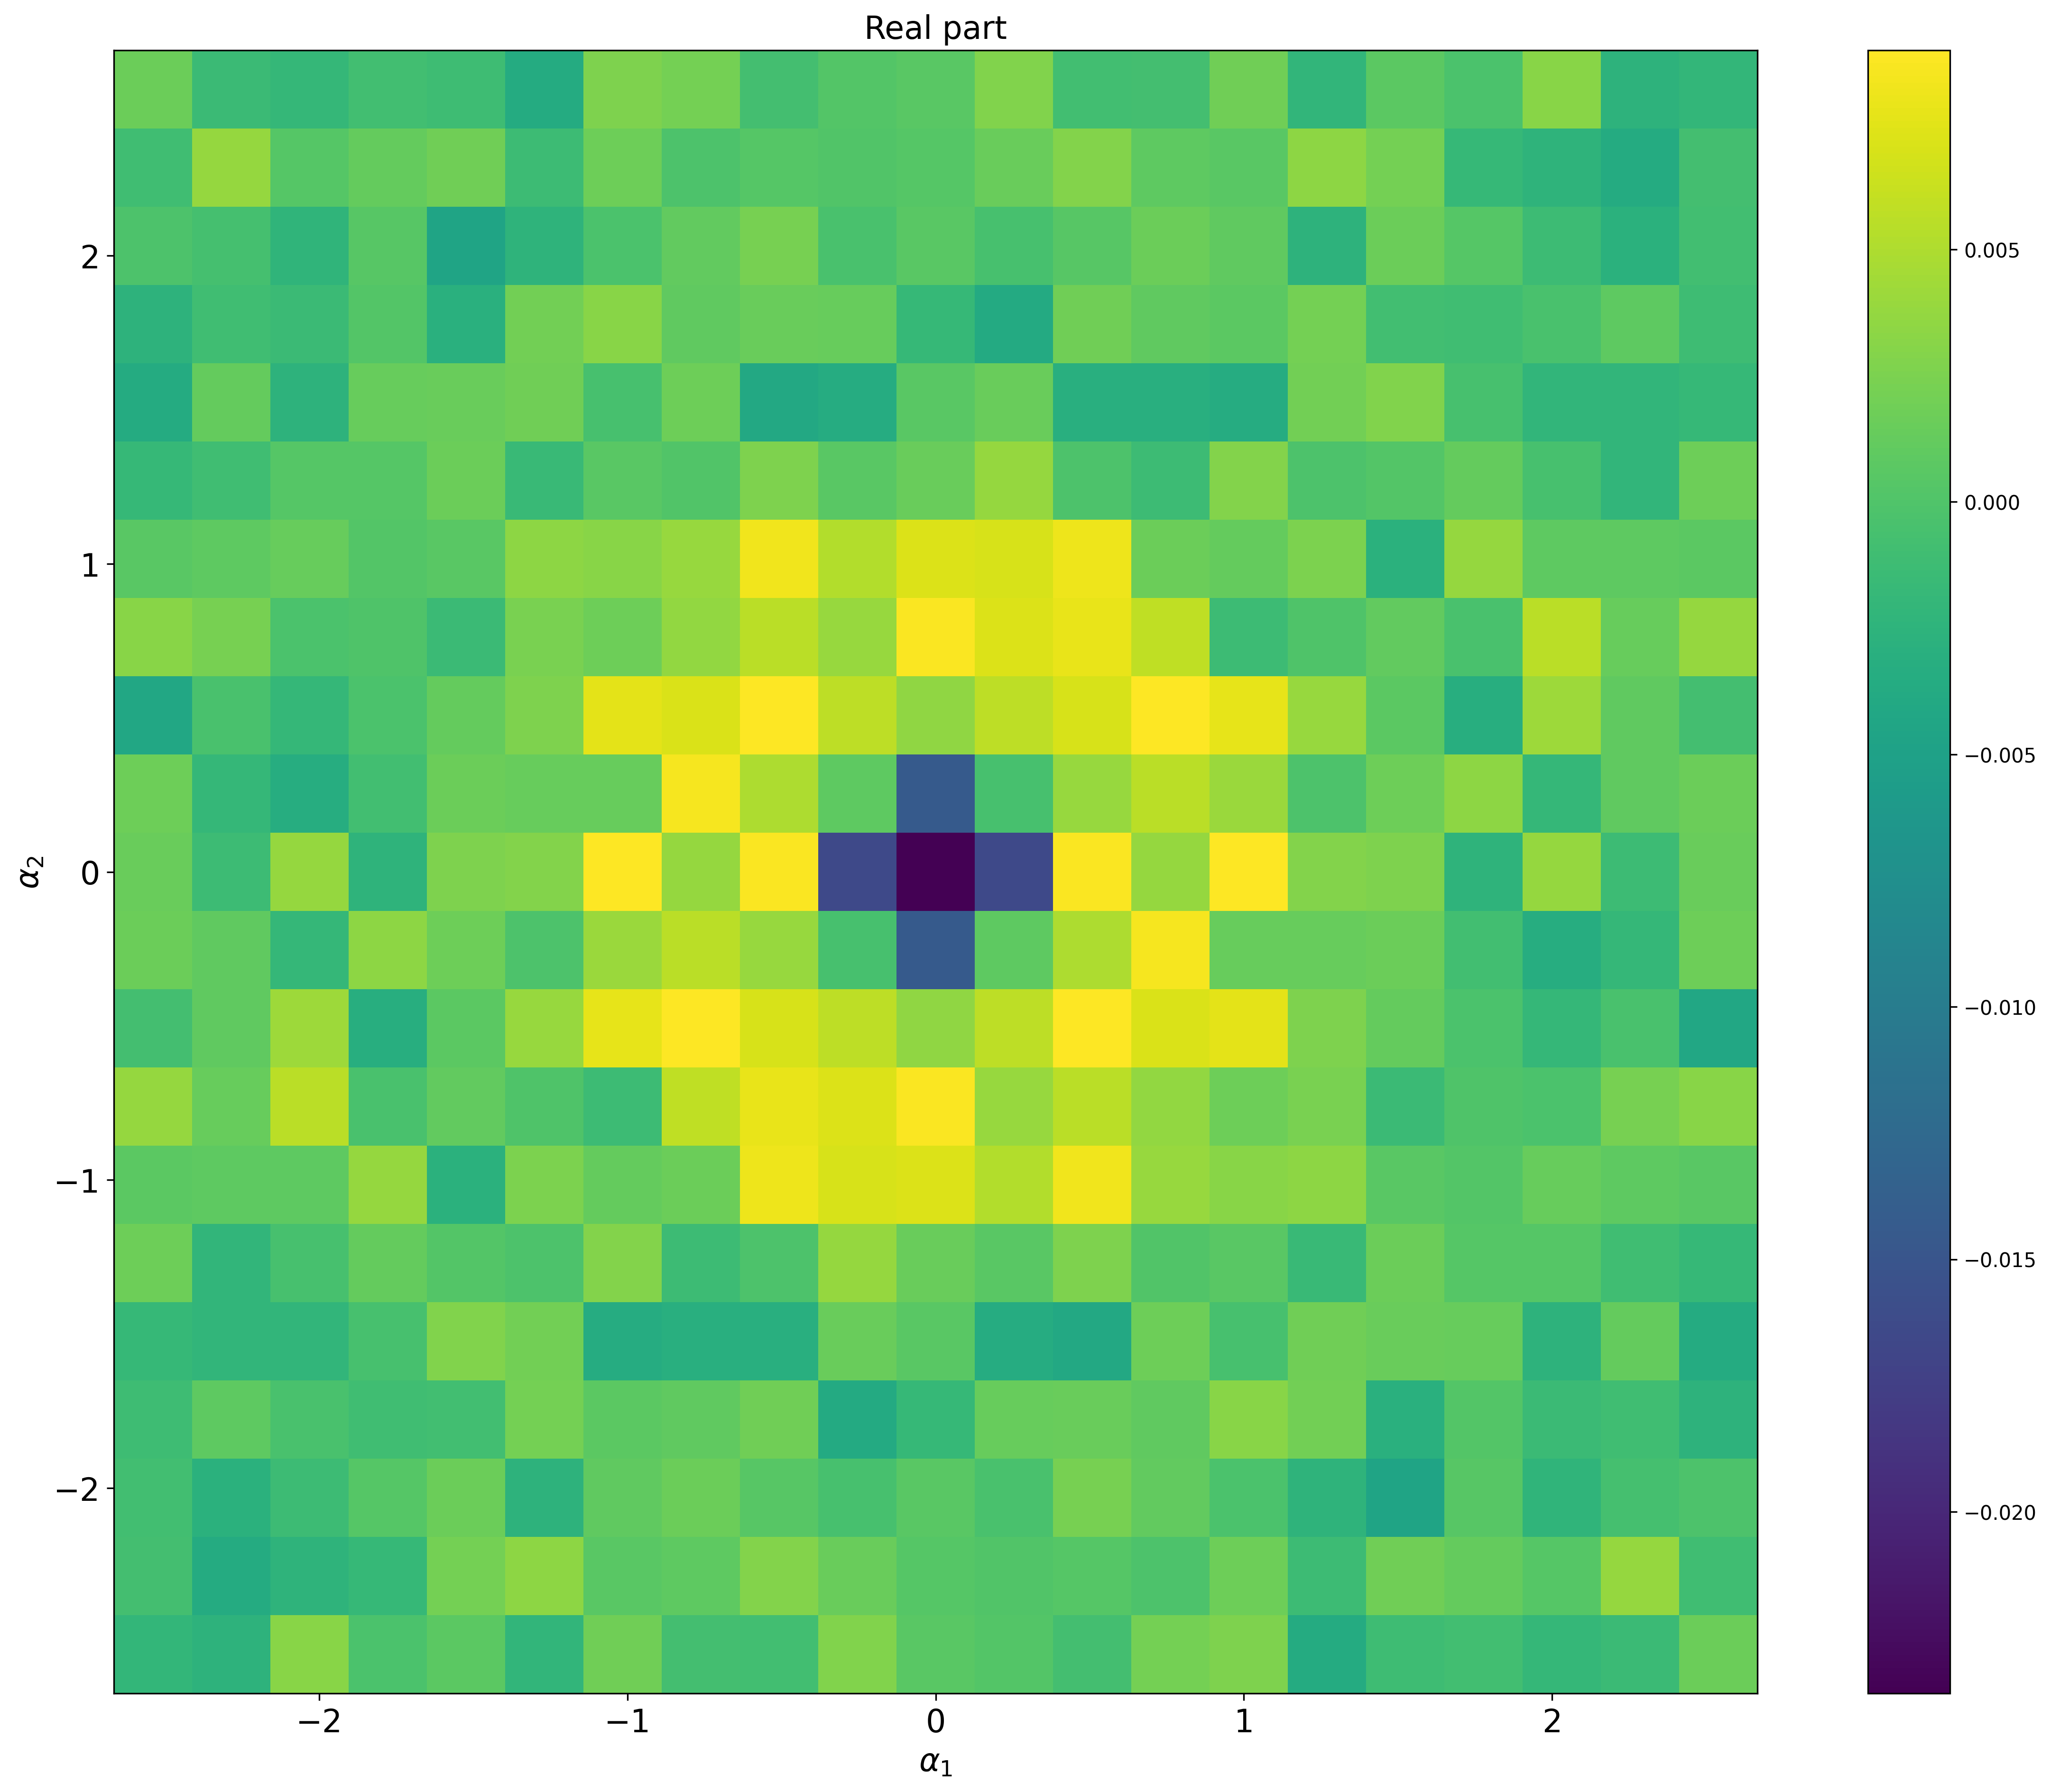

In [190]:
#pmt_count_tmp=pmt_count.copy()
pmt_count_tmp=pmt_interpolate.copy()

pmt_count_tmp=np.nan_to_num(pmt_count_tmp, nan=0)

#padding
pmt_padding =np.pad(pmt_count_tmp-offset, pad_width=0, mode='constant', constant_values=0.)

#shift the data to the center
pmt_padding_shift=np.zeros((len(pmt_padding),len(pmt_padding)))
pmt_padding_shift[len(pmt_padding)//2+1:,len(pmt_padding)//2+1:]=pmt_padding[:len(pmt_padding)//2,:len(pmt_padding)//2]
pmt_padding_shift[:len(pmt_padding)//2+1,:len(pmt_padding)//2+1]=pmt_padding[len(pmt_padding)//2:,len(pmt_padding)//2:]
pmt_padding_shift[:len(pmt_padding)//2+1,len(pmt_padding)//2+1:]=pmt_padding[len(pmt_padding)//2:,:len(pmt_padding)//2]
pmt_padding_shift[len(pmt_padding)//2+1:,:len(pmt_padding)//2+1]=pmt_padding[:len(pmt_padding)//2,len(pmt_padding)//2:]

# Apply Gaussian window to data before FFT
sigma =1000# Width of Gaussian window
x = np.linspace(0, len(pmt_padding), len(pmt_padding))
y = np.linspace(0, len(pmt_padding), len(pmt_padding))
X, Y = np.meshgrid(x, y)
gaussian = np.exp(-(X**2 + Y**2)/(2*sigma**2))
gaussian = gaussian / gaussian.sum()  # Normalize

# Multiply data by window function then take FFT
chi_transformed = np.fft.fft2(pmt_padding_shift * gaussian)

# chi = chi_transformed
fft_tmp = np.fft.fftshift(chi_transformed)
#np.fft.fftshift(np.fft.fft2(pmt_padding_shift))


alpha_axis1=np.fft.fftshift(np.fft.fftfreq(len(pmt_padding), 2*np.abs(beta_range1)/(len(pmt_count)-1)))*2*np.sqrt(2) #factors for be consistent with qutip wigner 

alpha_axis2=np.fft.fftshift(np.fft.fftfreq(len(pmt_padding), 2*np.abs(beta_range2)/(len(pmt_count)-1)))*2*np.sqrt(2)


plt.figure(figsize=(20,15), dpi=300)

plt.imshow(np.real(fft_tmp), cmap=cmap, extent=[alpha_axis1[0], alpha_axis1[-1], alpha_axis2[0], alpha_axis2[-1]])
plt.xlabel('$\\alpha_1$',fontsize=16)
plt.ylabel('$\\alpha_2$',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar()
plt.title('Real part', fontsize=16)




In [191]:
eta1*0.078*120/2*2*np.pi

3.9403111698384627